In [1]:
from matplotlib import pyplot as plt
import seaborn as sbn
import numpy as np
import torch
import pandas as pd

from gsnn.models.GSNN import GSNN
from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.simulate.datasets import simulate_3_in_3_out
import time

# for reproducibility 
torch.manual_seed(0)
np.random.seed(0)

%load_ext autoreload
%autoreload 2

import torch

/home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


# Gradient checkpointing and compiling

In [2]:
G, pos, x_train, x_test, y_train, y_test, \
    input_nodes, function_nodes, output_nodes = simulate_3_in_3_out(n_train=10, n_test=1, noise_scale=0.1)

In [3]:
kwargs = {'channels': 10, 
          'share_layers': False, 
          'bias': True, 
          'add_function_self_edges': True, 
          'norm': 'none', 
          'residual': True, 
          'dropout': 0.}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
data = nx2pyg(G, input_nodes, function_nodes, output_nodes) 

In [4]:
def memory_usage(model, x_train): 
    torch.cuda.reset_peak_memory_stats()
    model(x_train.to(device))
    return torch.cuda.max_memory_allocated() / 1e6 

def time_usage(model, x_train, n=50): 
    times = []
    for i in range(n): 
        start = time.time()
        model(x_train.to(device))
        times.append(time.time() - start)
    return np.mean(times)

In [5]:

res = {'layers':[], 'mem_no_ckpt':[], 'time_no_ckpt':[], 'mem_ckpt':[], 'time_ckpt':[]}

for layers in np.linspace(5,100,25):
    print(f'progress: {layers:.2f}%', end='\r') 
    layers = int(layers)

    model_no_ckpt = GSNN(data.edge_index_dict,
                        data.node_names_dict, 
                        checkpoint=False, 
                        layers=layers, 
                        **kwargs).to(device)

    model_ckpt = GSNN(data.edge_index_dict,
                        data.node_names_dict, 
                        checkpoint=True, 
                        layers=layers, 
                        **kwargs).to(device)

    res['layers'].append(layers)
    res['mem_no_ckpt'].append(memory_usage(model_no_ckpt, x_train))
    res['time_no_ckpt'].append(time_usage(model_no_ckpt, x_train))
    res['mem_ckpt'].append(memory_usage(model_ckpt, x_train))
    res['time_ckpt'].append(time_usage(model_ckpt, x_train))

res = pd.DataFrame(res)

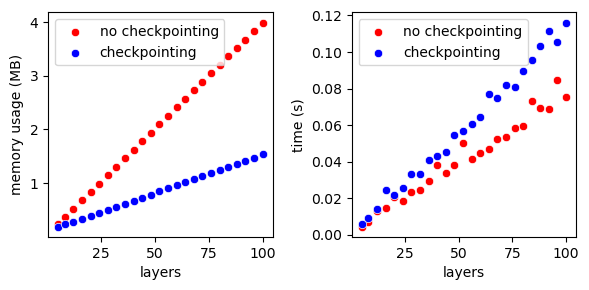

In [6]:
f,axes = plt.subplots(1,2, figsize=(6,3))
sbn.scatterplot(data=res, x='layers', y='mem_no_ckpt', color='red', label='no checkpointing', ax=axes[0])
sbn.scatterplot(data=res, x='layers', y='mem_ckpt', color='blue', label='checkpointing', ax=axes[0])

sbn.scatterplot(data=res, x='layers', y='time_no_ckpt', color='red', label='no checkpointing', ax=axes[1])
sbn.scatterplot(data=res, x='layers', y='time_ckpt', color='blue', label='checkpointing', ax=axes[1])

axes[0].set_ylabel('memory usage (MB)')
axes[1].set_ylabel('time (s)')
axes[0].set_xlabel('layers')
axes[1].set_xlabel('layers')
plt.tight_layout()
plt.show()

In [ ]:
# percent change in memory usage 
# using checkpointing on average has a ~55% decrease in memory usage 
((res.mem_ckpt - res.mem_no_ckpt)/res.mem_no_ckpt*100).mean()

-55.98707583757151

In [8]:
# percent change in runtime 
# using checkpointing on average has a ~40% increase in runtime. 
((res.time_ckpt - res.time_no_ckpt)/res.time_no_ckpt*100).mean() 

38.75115191237275